In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

In [2]:
df = pd.read_csv("../dpt_distance_calibration.csv")

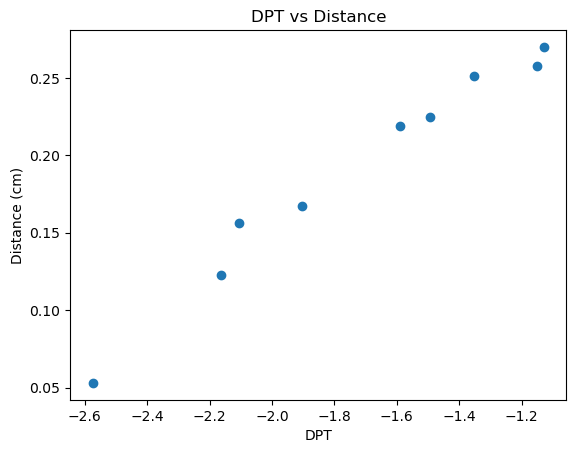

In [3]:
fig = plt.figure()

plt.show()

In [5]:
interp_current = interp1d(
    df["distance"],
    df["dpt"],
    kind="linear",
    fill_value="extrapolate",
)

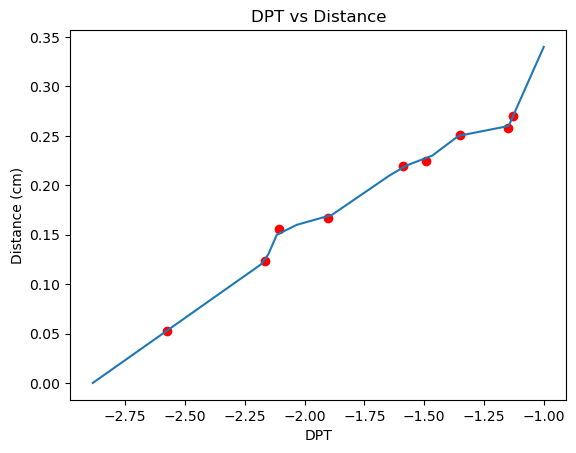

In [13]:
dpt = []
i_s = []

for i in np.arange(0, 0.35, 0.01):
    i_s.append(i)
    dpt.append(interp_current(i))

fig = plt.figure()
plt.plot(dpt, i_s)
plt.scatter(df["dpt"], df["distance"], color="red")
plt.xlabel("DPT")
plt.ylabel("Distance (cm)")
plt.title("DPT vs Distance")
plt.show()

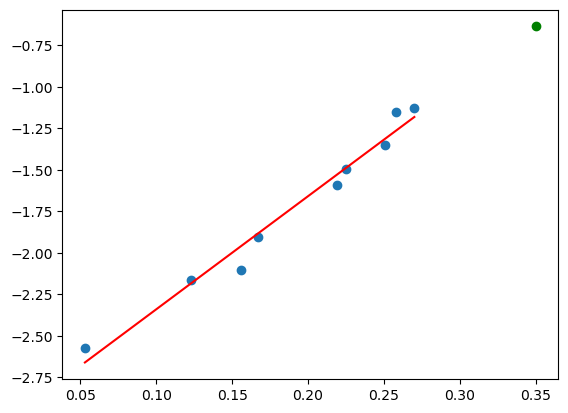

In [16]:
# use linear regression to predit dpt from distance
from sklearn.linear_model import LinearRegression

X = df["distance"].values.reshape(-1, 1)
y = df["dpt"].values

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
fig = plt.figure()
plt.scatter(X, y)
plt.plot(X, y_pred, color="red")

x_out = 0.35
y_out = model.predict([[x_out]])

plt.scatter(x_out, y_out, color="green")
plt.show()